# 아래에서 갱신하고자 하는 기업명을 company_list에 채워주세요!
- 38커뮤니케이션과 IPO stock에 올라온 기업명이 다를 경우가 있습니다.
- 그런 경우에는 IPO stock 수요예측결과에 올라온 기업명으로 입력해주세요.

### path

In [1]:
import os

# 파일이 있는 현재 위치를 path로 지정
current_directory = os.getcwd()
path = current_directory.replace('\\', '/')
path += '/' if not path.endswith('/') else ''

data_path = path + "data/"
print("Data_path :", data_path)

img_path = path + "img/"
print("IMG_path :", img_path)

#필요시 path 재조정
# path = 'C:/Users/sook7/미래에솦_주피터/본선코드정리/'
# data_path = path + "data/"
# img_path = path + "img/"

save_to = path + 'streamlit_mockup/data/'

Data_path : C:/Users/sook7/미래에솦_주피터/[빅데이터_미래에솦]소스코드/data/
IMG_path : C:/Users/sook7/미래에솦_주피터/[빅데이터_미래에솦]소스코드/img/


In [2]:
#패키지 호출

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException

from bs4 import BeautifulSoup

import requests
from urllib.request import urlopen
from urllib.parse import quote_plus
from urllib.parse import urlparse
from pandas.io.html import read_html
import time
import sys
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

# 주피터 노트북 이미지 삽입 라이브러리
from IPython.display import Image

pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.

# (Jupyter)_7_code_modeling_input자동화의 코드 흐름입니다.
- company_list를 입력받아 해당 기업의 정보를 크롤링합니다.
- 전처리한 뒤 모델을 가져와 점수를 도출하고 model_df, streamlit_df에 새로운 기업에 대한 정보를 추가합니다.

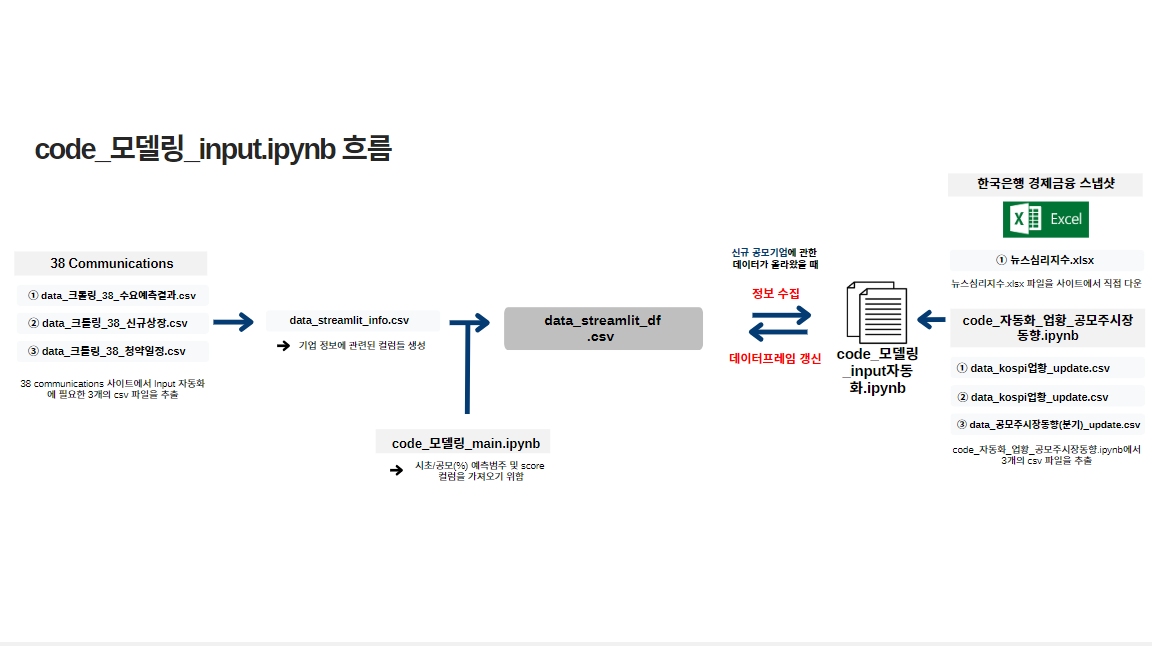

In [3]:
Image(filename = img_path +'code_모델링_input자동화.png')

# 업데이트가 필요한 기업명 작성

- 1. company_list에 원하는 기업목록 작성 (IPO stock의 기업명으로 작성해야함)
- 2. run all 실행

In [4]:
# 원하는 기업 목록 
company_list = ['시큐레터']

# 싸이킷런 버전 1.3.0 필요

# input 자동화에 필요한 csv 파일 (같은 폴더에 위치해야함)

### data_KOSPI/KOSDAQ업황_update
### data_공모주시장동향(분기)
- 해당 코드 실행 전 code_자동화_업황_공모주시장동향 실행이 필요

### 뉴스심리지수 
https://snapshot.bok.or.kr/search/%EB%89%B4%EC%8A%A4%EC%8B%AC%EB%A6%AC%EC%A7%80%EC%88%98
- 한국은행 스냅샷에서 xlsx다운로드하여 같은 폴더내에 위치시키기


# 38communication 크롤링 함수

In [5]:
def crawling_38(company_list):
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.implicitly_wait(2) 
    driver.get('http://www.38.co.kr/html/fund/index.htm?o=r1')

    df_df = pd.DataFrame()
    df_ls = pd.DataFrame()
    df_sc = pd.DataFrame()

    for company_name in company_list:
        for page in range(1, 4):  # 최대 3페이지까지 수집
            ### 수요예측결과 페이지
            url = f"https://www.38.co.kr/html/fund/index.htm?o=r1&page={page}"
            response = requests.get(url)
            response.raise_for_status()

            # HTML 파싱
            soup = BeautifulSoup(response.text, 'html.parser')

            # 테이블 선택 및 파싱
            table = soup.find('table', summary="수요예측결과")
            headers = [header.get_text().strip() for header in table.find_all('th')]
            rows = [[col.get_text().strip() for col in row.find_all('td')] for row in table.find_all('tr')]

            # DataFrame 생성 및 추가
            df_df_temp = pd.DataFrame(rows[2:], columns=headers)  # 첫 번째 행은 헤더와 동일하므로 제거
            if company_name in df_df_temp['기업명'].values:
                df_df_temp = df_df_temp[df_df_temp['기업명'].str.contains(company_name)]
                df_df_temp['기업명'] = company_name 
                
                # 종목코드 가져오기
                target_text = company_name
                element = None
                for link in soup.find_all('a'):
                    if target_text in link.text:
                        element = link
                        break

                if element:
                    # 해당 링크로 이동
                    link = 'http://www.38.co.kr/html/fund/' + element.attrs['href']
                    if link:
                        driver.get(link)
                        종목코드 = driver.find_element(By.XPATH, "/html/body/table[3]/tbody/tr/td/table[1]/tbody/tr/td[1]/table[2]/tbody/tr[2]/td[4]")
                        종목코드 = 종목코드.text.strip()
                        driver.back()
                    else:
                        print("링크를 찾을 수 없습니다.")
                        break
                else:
                    print("텍스트를 찾을 수 없습니다.")
                    break

                df_df_temp['종목코드'] = 종목코드
                break
                
            else:
                print(f'수요예측결과 {page} 페이지에는 {company_name}이 없습니다.')
            
        #company_name에 대한 기업정보 저장
        df_df = pd.concat([df_df, df_df_temp])
            
            ### 신규상장 페이지
        
        for page in range(1, 4):  # 최대 3페이지까지 수집
            ### 수요예측결과 페이지
            url = f"https://www.38.co.kr/html/fund/index.htm?o=nw&page={page}"
            response = requests.get(url)
            response.raise_for_status()

            # HTML 파싱
            soup = BeautifulSoup(response.text, 'html.parser')

            # 테이블 선택 및 파싱
            table = soup.find('table', summary="신규상장종목")
            headers = [header.get_text().strip() for header in table.find_all('th')]
            rows = [[col.get_text().strip() for col in row.find_all('td')] for row in table.find_all('tr')]

            # DataFrame 생성 및 추가
            df_ls_temp = pd.DataFrame(rows[2:], columns=headers)  # 첫 번째 행은 헤더와 동일하므로 제거
            if company_name in df_ls_temp['기업명'].values:
                df_ls_temp = df_ls_temp[df_ls_temp['기업명'].str.contains(company_name)]
                df_ls_temp['기업명'] = company_name 
                break
            
            else:
                print(f'신규상장 {page} 페이지에는 {company_name}이 없습니다.')
                        
        #company_name에 대한 기업정보 저장
        df_ls = pd.concat([df_ls, df_ls_temp])
            
        for page in range(1, 4):  # 최대 3페이지까지 수집
            ### 공모주 청약일정 페이지
            url = f"http://www.38.co.kr/html/fund/index.htm?o=k&page={page}"
            response = requests.get(url)
            response.raise_for_status()

            # HTML 파싱
            soup = BeautifulSoup(response.text, 'html.parser')

            # 테이블 선택 및 파싱
            table = soup.find('table', summary="공모주 청약일정")
            headers = [header.get_text().strip() for header in table.find_all('th')]
            rows = [[col.get_text().strip() for col in row.find_all('td')] for row in table.find_all('tr')]

            # DataFrame 생성 및 추가
            df_sc_temp = pd.DataFrame(rows[2:], columns=headers)  # 첫 번째 행은 헤더와 동일하므로 제거
            if company_name in df_sc_temp['종목명'].values:
                df_sc_temp = df_sc_temp[df_sc_temp['종목명'].str.contains(company_name)]
                df_sc_temp['종목명'] = company_name 
                break
            
            else:
                print(f'공모청약일정 {page} 페이지에는 {company_name}이 없습니다.')


        #최종 저장
        df_sc = pd.concat([df_sc, df_sc_temp])

        # 서버에 부담을 주지 않기 위해 잠시 대기
        time.sleep(1)
    
    df = pd.merge(df_df, df_ls.drop('공모가(원)', axis=1), on='기업명', how='left')
    df_sc.rename(columns={'종목명' : '기업명'}, inplace=True)

    data_38 = pd.merge(df_df.drop(['공모금액(백만원)','기관경쟁률','의무보유확약'],axis=1), df_ls[['기업명', '신규상장일', '시초/공모(%)']], on='기업명', how='left')
    data_38 = pd.merge(data_38, df_sc[['기업명','공모주일정']], on='기업명', how='left')
    
    driver.quit()
    return df, data_38

# IPO stock 크롤링 함수

In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def get_shareholder_info_df(url, company_name, stock_code):
    response = requests.get(url)
    html = response.content.decode('utf-8', 'replace')
    soup = BeautifulSoup(html, 'lxml')
    
    try:
        table = soup.select('table[class="view_tb"]')[2] #유통 가능 정보 테이블
        table_rows = table.find_all('tr')

        shares_info = []

        idx = -1
        while len(shares_info) < 3:
            tds = table_rows[idx].find_all('td')
            idx = idx - 1
            target_text = tds[0].text.strip().replace('\t', '').replace('\r\n', '')

            if target_text in ['공모후 상장주식수', '유통가능주식합계', '보호예수물량합계']:
                number_of_shares = int(tds[1].text.strip().replace('주', '').replace(',', ''))
                ratio_of_shares = tds[3].text.strip().replace(' ', '')
                shares_info.append([number_of_shares, ratio_of_shares])

        # If shareholder_info is not found, return an empty DataFrame
        if len(shares_info) < 3:
            return pd.DataFrame()    

        shareholder_info_df = pd.DataFrame({'기업명': company_name,
                                            '종목코드': stock_code,
                                            '공모후 상장주식수(주식수)': shares_info[0][0],
                                            '공모후 상장주식수(비율)': shares_info[0][1],
                                            '유통가능주식합계(주식수)': shares_info[1][0],
                                            '유통가능주식합계(비율)': shares_info[1][1],
                                            '보호예수물량합계(주식수)': shares_info[2][0],
                                            '보호예수물량합계(비율)': shares_info[2][1]}, index=[0])
        return shareholder_info_df
    
    except IndexError:
        return pd.DataFrame()

def get_demand_forcasting_df(XPATH, company_name, stock_code):
    tbody = XPATH.find_element(By.TAG_NAME, 'tbody')
    trs = tbody.find_elements(By.TAG_NAME, 'tr')
    기관경쟁률 = trs[0]
    의무보유 = trs[2]
    
    tds = 기관경쟁률.find_elements(By.TAG_NAME, 'td')
    td = tds[1]
    strong_element = td.find_element(By.TAG_NAME, 'font').find_element(By.TAG_NAME, 'strong')
    if strong_element:
        text_value = strong_element.text
        if ',' in text_value:
            compete_rate = float(text_value[:-2].strip().replace(',', ''))
        elif text_value == '':
            compete_rate = 0
        else:
            compete_rate = float(text_value[:-2].strip())
    else:
        compete_rate = 0
    
    tds = 의무보유.find_elements(By.TAG_NAME, 'td')
    td = tds[1]
    if td.text.strip():
        text_value = td.text
        if '-' in text_value:
            commitment = 0
        elif text_value == '':
            commitment = 0
        else:
            commitment = float(td.text.strip().replace('%',''))
    else:
        commitment = 0

    forecasting_df = pd.DataFrame({'기업명': company_name,
                                   '종목코드': stock_code,
                                   '기관경쟁률': compete_rate,
                                   '의무보유확약': commitment}, index=[0])
    return forecasting_df

def get_financial_df(url, company_name, driver, stock_code):
    response = requests.get(url)
    html = response.content.decode('utf-8', 'replace')
    soup = BeautifulSoup(html, 'lxml')
    table = soup.select('table[class="view_tb"]')[0] #재무정보 테이블
    table_rows = table.find_all('tr')
   
    당기 = []
    전기 = []
    전전기 = []
    
    
    #재무정보표 데이터 추가 
    idx = 0
    while idx < len(table_rows) and len(당기) < 16:
        tds = table_rows[idx].find_all('td')
        idx = idx + 1
        target_text = tds[0].text.strip().replace('\t','').replace('\r\n','')
        
        
        if any(text in target_text for text in ['구분', '유동자산', '비유동자산', '자산총계', '유동부채', '비유동부채', '부채총계', '자본금', '자본잉여금', '이익잉여금', '기타자본항목', '자본총계', '매출액','영업수익', '영업이익', '당기순이익']):
            
            if target_text == '구분':
                당기.append(tds[1].text.strip())
                전기.append(tds[2].text.strip())
                전전기.append(tds[3].text.strip())
            
            else:
                if '.' in tds[1].text.strip():
                    당기.append(float(tds[1].text.strip().replace(',', '')))
                else:
                    당기.append(int(tds[1].text.strip().replace(',', '')))

                if '.' in tds[2].text.strip():
                    전기.append(float(tds[2].text.strip().replace(',', '')))
                else:
                    전기.append(int(tds[2].text.strip().replace(',', '')))

                if '.' in tds[3].text.strip():
                    전전기.append(float(tds[3].text.strip().replace(',', '')))
                else:
                    전전기.append(int(tds[3].text.strip().replace(',', '')))
    
    try:
        당기.append(table_rows[1].find_all('td')[0].text.strip())
        전기.append(table_rows[1].find_all('td')[1].text.strip())
        전전기.append(table_rows[1].find_all('td')[2].text.strip())
    except IndexError:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    
    #재무정보표 KRW 단위정보 추가 
    table = driver.find_element(By.XPATH, '//*[@id="print"]/table/tbody/tr[6]/td/table[1]')
    tbody = table.find_element(By.TAG_NAME, 'tbody')
    tr = tbody.find_elements(By.TAG_NAME, 'tr')[0]
    td = tr.find_elements(By.TAG_NAME, 'td')[1]
    font = td.find_element(By.TAG_NAME, 'font')
    
    if len(font.text) > 0:
        당기.append(font.text.strip())
        전기.append(font.text.strip())
        전전기.append(font.text.strip())
    else:
        당기.append('-')
        전기.append('-')
        전전기.append('-')
    

    try:
        당기_df = pd.DataFrame({'종목명': company_name,
                                      '종목코드': stock_code,
                                       '구분1': 당기[0],
                                       '구분2': 당기[15],
                                        '단위' : 당기[16],
                                       '유동자산': 당기[1],
                                        '비유동자산' : 당기[2],
                                         '자산총계' : 당기[3],
                                         '유동부채' : 당기[4],
                                         '비유동부채' : 당기[5],
                                         '부채총계' : 당기[6],
                                         '자본금' : 당기[7],
                                         '자본잉여금' : 당기[8],
                                         '이익잉여금' : 당기[9],
                                         '기타자본항목' : 당기[10],
                                         '자본총계' : 당기[11],
                                         '매출액' : 당기[12],
                                         '영업이익' : 당기[13],
                                         '당기순이익' : 당기[14]}, index=[0])

        전기_df = pd.DataFrame({'종목명': company_name,
                                      '종목코드': stock_code,
                                       '구분1': 전기[0],
                                        '구분2' : 전기[15],
                                        '단위' : 전기[16],
                                       '유동자산': 전기[1],
                                        '비유동자산' : 전기[2],
                                         '자산총계' : 전기[3],
                                         '유동부채' : 전기[4],
                                         '비유동부채' : 전기[5],
                                         '부채총계' : 전기[6],
                                         '자본금' : 전기[7],
                                         '자본잉여금' : 전기[8],
                                         '이익잉여금' : 전기[9],
                                         '기타자본항목' : 전기[10],
                                         '자본총계' : 전기[11],
                                         '매출액' : 전기[12],
                                         '영업이익' : 전기[13],
                                         '당기순이익' : 전기[14]}, index=[0])

        전전기_df = pd.DataFrame({'종목명': company_name,
                                       '종목코드': stock_code,
                                       '구분1': 전전기[0],
                                        '구분2' : 전전기[15],
                                        '단위' : 전전기[16],
                                       '유동자산': 전전기[1],
                                        '비유동자산' : 전전기[2],
                                         '자산총계' : 전전기[3],
                                         '유동부채' : 전전기[4],
                                         '비유동부채' : 전전기[5],
                                         '부채총계' : 전전기[6],
                                         '자본금' : 전전기[7],
                                         '자본잉여금' : 전전기[8],
                                         '이익잉여금' : 전전기[9],
                                         '기타자본항목' : 전전기[10],
                                         '자본총계' : 전전기[11],
                                         '매출액' : 전전기[12],
                                         '영업이익' : 전전기[13],
                                         '당기순이익' : 전전기[14]}, index=[0])       
    except IndexError:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
            
        
    return 당기_df, 전기_df, 전전기_df

In [7]:
def crawling_IPO(company_list):
    ipo_forcasting_df = pd.DataFrame()
    ipo_stock_df = pd.DataFrame()
    ipo_now_df = pd.DataFrame()
    ipo_pre_df = pd.DataFrame()
    ipo_prepre_df = pd.DataFrame()
    
    #ipo_now, ipo_pre, ipo_prepre를 구성하기 위함 
    now_info = pd.DataFrame()
    pre_info = pd.DataFrame()
    prepre_info = pd.DataFrame()

    #selenium 크롬 드라이버 설정 
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.implicitly_wait(2) 
    driver.get('http://www.ipostock.co.kr/sub03/ipo08.asp')
    
    #전체보기 클릭
    show_all_box = driver.find_element(By.XPATH, '//*[@id="print"]/table[1]/tbody/tr[3]/td/table/tbody/tr[1]/td[14]/a')
    show_all_box.click()
    
    table = driver.find_element(By.XPATH,'//*[@id="print"]/table[1]/tbody/tr[4]/td/table/tbody/tr[2]/td/table')
    tbody = table.find_element(By.TAG_NAME,'tbody')
    
    for company_name in company_list:
        company_found = False  # Flag to check if the company is found
        
        # 1부터 3페이지까지 순환
        for page in range(1, 4):
            driver.get(f'http://www.ipostock.co.kr/sub03/ipo08.asp?str1=&str2=&str3=&str4=2023&str5=all&page={page}')
            table = driver.find_element(By.XPATH,'//*[@id="print"]/table[1]/tbody/tr[4]/td/table/tbody/tr[2]/td/table')
            tbody = table.find_element(By.TAG_NAME,'tbody')
        
            #기업명 하나씩 클릭하면서 세부정보 확인
            for tr in tbody.find_elements(By.TAG_NAME, 'tr'):
                tds = tr.find_elements(By.TAG_NAME, 'td')
                # 세 번째 td 요소가 존재하지 않으면 다음 tr을 검사
                if len(tds) <= 2:  
                    continue

                td = tds[2]  # 세 번째 td 요소에 접근
                td_table = td.find_element(By.TAG_NAME,'table')
                td_body = td_table.find_element(By.TAG_NAME,'tbody')
                td_td = td_body.find_element(By.TAG_NAME,'tr').find_elements(By.TAG_NAME, 'td')
                링크_element = td_td[1].find_element(By.TAG_NAME,'a')

                if 링크_element:
                    링크 = 링크_element.get_attribute('href')
                    driver.get(링크)

                    ##수요예측 탭 

                    #기업 이름, 종목코드
                    name_td = driver.find_element(By.XPATH,'//*[@id="print"]/table/tbody/tr[3]/td/table/tbody/tr/td[1]/table/tbody/tr[1]/td/table/tbody/tr/td[1]')
                    strong_elements = name_td.find_elements(By.TAG_NAME,'strong')

                    # strong_elements가 존재하지 않으면 continue
                    if len(strong_elements) < 2:
                        driver.back()
                        continue

                    # strong_elements[0] : 기업명 / strong_elements[1] : 종목코드
                    name = strong_elements[0].text
                    stock_code = strong_elements[1].text
                    
                    if company_name != name:
                        driver.back()
                        continue

                    # Set the flag to True when the company is found
                    company_found = True

                    # 기관경쟁률, 의무보유확약
                    try:
                        forcasting_table = driver.find_element(By.XPATH, '//*[@id="print"]/table/tbody/tr[5]/td/table[5]') 
                        ipo_forcasting_df = pd.concat([ipo_forcasting_df, get_demand_forcasting_df(forcasting_table, company_name, stock_code)], axis=0)
                    except NoSuchElementException:
                        driver.back()
                        continue

                    ##재무정보 탭으로 이동 

                    try:
                        재무정보_box = driver.find_element(By.XPATH,'//*[@id="print"]/table/tbody/tr[5]/td/table/tbody/tr[1]/td[3]/a')
                        link = 재무정보_box.get_attribute('href')
                        재무정보_box.click()

                        # 가끔 재무정보 탭 클릭시 어도비 설치 문구 등장. 무시하는 코드
                        try:
                            alert = driver.switch_to.alert
                            alert.dismiss()
                        except:
                            pass

                    except NoSuchElementException:
                        driver.back()
                        continue

                    now_info, pre_info, prepre_info = get_financial_df(link, company_name, driver, stock_code)
                    ipo_now_df = pd.concat([ipo_now_df, now_info], axis=0)
                    ipo_pre_df = pd.concat([ipo_pre_df, pre_info], axis=0)
                    ipo_prepre_df = pd.concat([ipo_prepre_df, prepre_info], axis=0)

                    ##주주구성 탭으로 이동
                    try:
                        주주구성_box = driver.find_element(By.XPATH,'//*[@id="print"]/table/tbody/tr[5]/td/table[1]/tbody/tr[1]/td[2]/a')
                        link = 주주구성_box.get_attribute('href')
                        주주구성_box.click()
                    except NoSuchElementException:
                        driver.back()
                        driver.back()
                        continue


                    ipo_stock_df = pd.concat([ipo_stock_df, get_shareholder_info_df(link, company_name, stock_code)], axis=0)

                    driver.back()
                    driver.back()
                    driver.back()

                    break

                else:
                    print('링크를 찾지 못했습니다.')
                    continue
                    
            # 기업명을 찾았으면 다음 기업 검색으로 넘어감
            if company_found:
                break

        # 기업명을 찾지 못하면 빈데이터프레임 반환
        if not company_found:
            print(f'"{company_name}" 을(를) 찾지 못했습니다.')
            ipo_forcasting_df = pd.concat([ipo_forcasting_df, pd.DataFrame()], axis=0)
            ipo_stock_df = pd.concat([ipo_stock_df, pd.DataFrame()], axis=0)
            ipo_now_df = pd.concat([ipo_now_df, pd.DataFrame()], axis=0)
            ipo_pre_df = pd.concat([ipo_pre_df, pd.DataFrame()], axis=0)
            ipo_prepre_df = pd.concat([ipo_prepre_df, pd.DataFrame()], axis=0) 


    df = pd.merge(ipo_stock_df, ipo_forcasting_df, on=['종목코드','기업명'], how='left')    
    
    driver.quit()
    
    return df, ipo_now_df, ipo_pre_df, ipo_prepre_df

# 1. get_finance_df

In [8]:
def multiply_by_unit(df):
    df_copy = df.copy()
    for index, row in df_copy.iterrows():
        unit = row['단위']
        
        if unit == 'KRW (천원)':
            multiplier = 1e3
        elif unit == 'KRW (백만원)':
            multiplier = 1e6
        elif unit == 'KRW (억원)':
            multiplier = 1e8
        elif unit == 'CNY':
            multiplier = 184  # 2023.08.19 기준 위안화
        elif unit == 'USD':
            multiplier = 1340 # 2023.08.19 기준 달러
        else:
            multiplier = 1
        
        numeric_columns = df_copy.drop(['종목명','종목코드','구분1','구분2','단위'],axis=1).columns
        df_copy.loc[index, numeric_columns] = df_copy.loc[index, numeric_columns] * multiplier
    return df_copy

In [9]:
# 연도 처리 위해 int로 리턴
def extract_year(row):
    # 년도 추출
    #years = [str(i) for i in range(2009, 2024)]
    years = [str(i) for i in range(2023, 2008, -1)]
    for year in years:
        if str(year) in str(row['구분1']):
            return int(year)
        elif str(year) in str(row['구분2']):
            return int(year)
    return 0


# 재무정보가 정확히 입력되어있지 않은 데이터에 대해 예외처리 해주기 위해 분기 변수 생성
def extract_quarter(row):
    # 분기 추출
    quaters = ["1분기", "반기", "3분기"]
    for quarter in quaters:
        if quarter in str(row['구분1']):
            return quarter
        elif quarter in str(row['구분2']):
            return quarter
    return 'None'

def year_분기_translate(df):
    # 년도와 분기 추출 후 변수 생성
    df['연도'] = df.apply(extract_year, axis=1)
    df['분기'] = df.apply(extract_quarter, axis=1)

    return df

In [10]:
# Finance 파생변수를 만들때 필요한 변수들을 합치고 생성
def merge_df(df_get, df_give):
        
    df_get = pd.merge(df_get, df_give[['종목코드', '상장년도','공모후 상장주식수(주식수)', '공모가(원)']], on='종목코드', how='left')

    df_get['EPS'] = df_get['당기순이익'] / df_get['공모후 상장주식수(주식수)']
    df_get["예상 시가총액"] = df_get['공모가(원)'] * df_get['공모후 상장주식수(주식수)']
    df_get["자기자본"] = df_get["자본금"] + df_get["자본잉여금"] + df_get["이익잉여금"]

    return df_get

In [11]:
def finance_func(df_1, df_2, df_3):
    df_finance = pd.DataFrame(columns=['종목코드', '종목명', '매출액 증감율', 'EPS 증감율', '자산비율', '유동비율', '예상 시가총액', 'PSR', 'ROE'], index=range(len(df_1)))
    for i in range(len(df_1)):
        pre_year_df = None
        prepre_year_df = None
        
        for df in [df_1, df_2, df_3]:
            if pd.notna(df["상장년도"][i]) and pd.notna(df['연도'][i]):
                if int(df["상장년도"][i]) - df['연도'][i] == 1:
                    pre_year_df = df
                elif int(df["상장년도"][i]) - df['연도'][i] == 2:
                    prepre_year_df = df
        
        if pre_year_df is not None and prepre_year_df is not None:
            df_finance.loc[i, "종목코드"] = df_1['종목코드'][i]
            df_finance.loc[i, "종목명"] = df_1['종목명'][i]
            
            df_finance.loc[i, "매출액 증감율"] = (pre_year_df['매출액'][i] - prepre_year_df['매출액'][i]) / abs(prepre_year_df['매출액'][i]) * 100
            df_finance.loc[i, "EPS 증감율"] = (pre_year_df['EPS'][i] - prepre_year_df['EPS'][i]) / abs(prepre_year_df['EPS'][i]) * 100
            
            df_finance.loc[i, "자산비율"] = pre_year_df['자산총계'][i] / (pre_year_df['자산총계'][i] - pre_year_df['부채총계'][i]) * 100            
            df_finance.loc[i, "유동비율"] = pre_year_df['유동자산'][i] / pre_year_df['유동부채'][i] * 100            
            df_finance.loc[i, "예상 시가총액"] = df_1['예상 시가총액'][i]
                            
            df_finance.loc[i, "PSR"] = pre_year_df['예상 시가총액'][i] / pre_year_df['매출액'][i]
            df_finance.loc[i, "ROE"] = pre_year_df['당기순이익'][i] / pre_year_df['자기자본'][i] * 100            
        
    for column in df_finance.drop(['종목코드','종목명'],axis=1).columns:
            if df_finance[column].dtype != 'float64':
                df_finance[column] = df_finance[column].astype(float)
                
    return df_finance

In [12]:
def get_finance_df(now, pre, prepre, df):
    data_ipo_now_mul = multiply_by_unit(now)
    data_ipo_pre_mul = multiply_by_unit(pre)
    data_ipo_prepre_mul = multiply_by_unit(prepre)
    
    df_now = year_분기_translate(data_ipo_now_mul)
    df_pre= year_분기_translate(data_ipo_pre_mul)
    df_prepre = year_분기_translate(data_ipo_prepre_mul)

    df_now = merge_df(df_now, df)
    df_pre = merge_df(df_pre, df)
    df_prepre = merge_df(df_prepre, df)
    
    # "분기" 열에 값에따라 재무정보 값 변경.
    index_1분기 = df_now[df_now["분기"] == "1분기"].index
    index_반기 = df_now[df_now["분기"] == "반기"].index
    index_3분기 = df_now[df_now["분기"] == "3분기"].index

    # 해당 행의 "매출액", "영업이익", "당기순이익" 열의 값에 1년의 재무정보를 추정할 수 있도록 수정.
    df_now.loc[index_1분기, ["매출액", "영업이익", "당기순이익"]] *= 4
    df_now.loc[index_반기, ["매출액", "영업이익", "당기순이익"]] *= 2
    df_now.loc[index_3분기, ["매출액", "영업이익", "당기순이익"]] *= 4/3
    
    df_1 = df_now.copy()
    df_2 = df_pre.copy()
    df_3 = df_prepre.copy()
    
    df_finance = finance_func(df_1, df_2, df_3)
    df_finance
    
    return df_finance

# 2. get_trend_df

In [13]:
# nsi_5를 구하는 함수 정의
def cal_nsi_5(nsi, df_trend):
    nsi.rename(columns={"Unnamed: 0": "날짜", "Unnamed: 1": "NSI"}, inplace=True)
    
    # 실제 값을 제외한 부분을 삭제
    nsi = nsi.iloc[6:, :]
    nsi.reset_index(drop=True, inplace=True)
    nsi["날짜"] = pd.to_datetime(nsi["날짜"])
    df_trend['신규상장일'] = pd.to_datetime(df_trend['신규상장일'])
    
    # 5일 평균 NSI
    for i in range(0, nsi.shape[0]):
        nsi.loc[i,'nsi_5'] = nsi.loc[i:i+4, 'NSI'].mean()
    
    for i in range(len(df_trend)):
        # 뉴스심리지수는 5일간의 뉴스를 토대로 만들어서 5일간의 것이 공백(내용 바꾸기)
        df_trend.at[i, "날짜"] = df_trend.at[i, "신규상장일"] - pd.DateOffset(days=6)
        
    df_trend = pd.merge(df_trend, nsi.drop('NSI',axis=1), on='날짜', how='inner')
    
    return df_trend

In [14]:
# 분기를 계산하는 함수 정의
def cal_quarter(month):
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    elif month in [10, 11, 12]:
        return 4

In [15]:
# 이전 분기를 계산하는 함수 정의
def cal_pre_quarter(year, quarter):
    if quarter == 1:
        return year - 1, 4
    else:
        return year, quarter - 1

In [16]:
# 이전 분기의 '공모주 시장 동향'을 계산하는 함수 정의
def cal_pre_quarter_market_trend(row, df_trend):
    previous_year, previous_quarter = row['이전 분기']
    previous_data = df_trend[(df_trend['상장년도'] == previous_year) & (df_trend['분기'] == previous_quarter)]
    if len(previous_data) > 0:
        previous_positive_percentage = previous_data[previous_data['시초/공모(%)'] > 0]
        return len(previous_positive_percentage) / len(previous_data)
    else:
        return np.nan

In [17]:
def get_trend_df(df):
    df_ksp = pd.read_csv(data_path + 'data_KOSPI업황_update.csv')
    df_kdq = pd.read_csv(data_path + 'data_KOSDAQ업황_update.csv')
    nsi = pd.read_excel(data_path + '뉴스심리지수.xlsx')
    df_market_trend = pd.read_csv(data_path + 'data_공모주시장동향(분기).csv')
    
    
    ksp_col_list = df_ksp.columns.values
    kdq_col_list = df_kdq.columns.values
    
    df['종목코드'] = df['종목코드'].astype(str).str.zfill(6)
    
    #datetime 형변환
    df['신규상장일'] = pd.to_datetime(df['신규상장일'])
    df['예측일'] = pd.to_datetime(df['예측일'])
    df_ksp['일자'] = pd.to_datetime(df_ksp['일자'])
    df_kdq['일자'] = pd.to_datetime(df_kdq['일자'])
    
    df_trend = df[['종목명','종목코드','신규상장일','예측일','상장년도','상장월', '시초/공모(%)']]
    
    df_trend = cal_nsi_5(nsi, df_trend)
    
    #input 입력받음 
    for index, row in enumerate(df_trend.itertuples()):
        print(f"[{df_trend.loc[index, '종목명']}]")
        print('')
        
        # 시장구분을 market에 저장
        while True:
            market = input("KOSPI / KOSDAQ : ").strip()
            if (market == "KOSPI") | (market == 'kospi') | (market == 'KOSDAQ') | (market == 'kosdaq'):
                if market == 'kospi':
                    market = "KOSPI"
                elif market == 'kosdaq':
                    market = "KOSDAQ"
                    
                break
            else:
                print('KOSPI / KOSDAQ 중 하나를 입력하세요.')
        
        #지수명1을 저장
        if market == 'KOSPI':
            print('')
            print("KOSPI 지수목록")
            print('')
            for i, col in enumerate(ksp_col_list, 1):
                print(col, end=" | ")
                if i % 5 == 0:
                    print()
            print()
            
            while True:
                factor1 = input("지수명1 : ").strip()  # 입력값에서 앞뒤 공백 제거
                if factor1 in ksp_col_list:
                    break
                else:
                    print("올바른 지수명을 입력하세요.")
                    print('')

            while True:
                factor2 = input("지수명2 (없으면 -) : ").strip()  # 입력값에서 앞뒤 공백 제거
                if (factor2 in ksp_col_list) or factor2 == '-':
                    break
                else:
                    print("올바른 지수명을 입력하세요.")
                    print('')
        else:
            print('')
            print("KOSDAQ 지수목록")
            print('')
            for i, col in enumerate(kdq_col_list, 1):
                print(col, end=" | ")
                if i % 5 == 0:
                    print()
            print()
            
            while True:
                factor1 = input("지수명1 : ").strip()  # 입력값에서 앞뒤 공백 제거
                if factor1 in kdq_col_list:
                    break
                else:
                    print("올바른 지수명을 입력하세요.")
                    print('')

            while True:
                factor2 = input("지수명2 (없으면 -) : ").strip()  # 입력값에서 앞뒤 공백 제거
                if (factor2 in kdq_col_list) or factor2 == '-':
                    break
                else:
                    print("올바른 지수명을 입력하세요.")
                    print('')
        
        df_trend.loc[index,'종목구분'] = market
        df_trend.loc[index,'지수명1'] = factor1
        df_trend.loc[index,'지수명2'] = factor2
    
    업황_list = []
    
    for index, row in df_trend.iterrows():
        #종목구분이 코스피이면, 코스피 날짜별 산업지수 테이블에서 값을 가져옴
        if row['종목구분'] == 'KOSPI':
            matching_row = df_ksp[df_ksp['일자'] == row['예측일']]

            if not matching_row.empty:
                if row['지수명2'] == '-':
                    if row['지수명1'] in ksp_col_list:  # 지수명1이 df_kdq의 열 중 하나인 경우
                        data = df_ksp.loc[matching_row.index, row['지수명1']].values[0]
                    else:  # 지수명1이 df_kdq의 열 중 하나가 아닌 경우
                        data = df_ksp.loc[matching_row.index, '기타서비스'].values[0]

                    업황_list.append(data)
     
                #지수명1, 지수명2 모두 존재할 경우 두 업황이 평균으로 업황 값 생성
                else:
                    data = ((df_ksp.loc[matching_row.index, row['지수명1']].values[0] + df_ksp.loc[matching_row.index, row['지수명2']].values[0])/ 2)
                    업황_list.append(data)
            else:
                data = '-1'  # 해당 조건을 만족하는 행이 없을 경우 처리
                업황_list.append(data)

        #종목구분이 코스닥이면, 코스닥 날짜별 산업지수 테이블에서 값을 가져옴        
        elif row['종목구분'] == 'KOSDAQ':
            matching_row = df_kdq[df_kdq['일자'] == row['예측일']]

            if not matching_row.empty:
                if row['지수명2'] == '-':
                    if row['지수명1'] in kdq_col_list:  # 지수명1이 df_kdq의 열 중 하나인 경우
                        data = df_kdq.loc[matching_row.index, row['지수명1']].values[0]
                    else:  # 지수명1이 df_kdq의 열 중 하나가 아닌 경우
                        data = df_kdq.loc[matching_row.index, '기타서비스'].values[0]

                    업황_list.append(data)

                else:
                    data = ((df_kdq.loc[matching_row.index, row['지수명1']].values[0] + df_kdq.loc[matching_row.index, row['지수명2']].values[0])/ 2)
                    업황_list.append(data)
            else:
                data = '-1'  # 해당 조건을 만족하는 행이 없을 경우 처리
                업황_list.append(data)
        else:
            data = '-1'
            업황_list.append(data)
                
    df_trend['업황'] = 업황_list
    
    # 분기를 계산하고 데이터프레임에 추가
    df_trend['분기'] = df_trend['상장월'].apply(cal_quarter)
    # 각 행에 대해 이전 분기를 계산하고 데이터프레임에 추가
    df_trend['이전 분기'] = df_trend.apply(lambda row: cal_pre_quarter(row['상장년도'], row['분기']), axis=1)
    
    df_trend['이전 분기'] = df_trend['이전 분기'].astype(str)
    df_market_trend['이전 분기'] = df_market_trend['이전 분기'].astype(str)
    
    # 각 행에 대해 이전 분기의 '공모주 시장 동향'을 계산하고 데이터프레임에 추가
    df_trend = pd.merge(df_trend, df_market_trend, on='이전 분기', how='left')
    
    #최종 df_trend
    df_trend['업황'] = df_trend['업황'].astype(float)
    df_trend = df_trend[['종목명','종목코드','시초/공모(%)','nsi_5','업황','공모주 시장 동향','종목구분','지수명1']]
    return df_trend

## 3. get_agent

In [18]:
def get_agent_df(df):
    
    # Agent에 필요한 컬럼 가져오기
    df_agent = df[['종목명','종목코드','유통가능주식합계(비율)', '기관경쟁률', '의무보유확약']] 
    # 컬럼 이름 수정
    df_agent.rename(columns={"유통가능주식합계(비율)": "유통가능물량비율", "의무보유확약": "의무보유확약비율"}, inplace=True)
    
#     # 공모밴드비율 파생변수를 위한 새로운 컬럼 생성
#     df_agent[['공모희망하단가', '공모희망상단가']] = df_agent['공모희망가'].str.split('~', expand=True)
#     df_agent['공모희망하단가'] = df_agent['공모희망하단가'].str.replace(',', '').astype(int)
#     df_agent['공모희망상단가'] = df_agent['공모희망상단가'].str.replace(',', '').astype(int)
    
    # 공모밴드비율 컬럼 생성
#     df_agent['공모밴드비율'] = 0.0
#     for i in df_agent.index:
#         df_agent.loc[i, '공모밴드비율'] = round((df_agent.loc[i, '공모가'] / ((df_agent.loc[i, '공모희망상단가'] + df_agent.loc[i, '공모희망하단가']) / 2)) * 100, 2)

#     # 공모금액(백만원) => (원)으로 바꾸기    
#     df_agent['공모금액'] *= 1000000
    
    # 필요없는 컬럼 제거
    # df_agent.drop(columns=['공모희망가','공모가'], inplace = True)
    
    return df_agent   

## df_ksp, df_kdq, data_sector 계속 갱신해서 저장해줘야함 
## data_sector 정보는 get_trend 함수 내에서 해당 기업의 종목구분, 지수명을 직접 input으로 넣어줘야 함
## 공모주 시장동향은 학습에 사용한 전체 df 셋이 필요함 

# main

- model_input을 만들고, 새로운 model_input을 추가한 model_df로 갱신
- input_df 결측치를 채울 때(재무정보가 inf일 경우), model_df의 값이 필요하기 때문에 model_df를 매개변수로 넣어줌

1. 기존 저장되어 있는 model.pkl에 input_df 넣어서 결과 도출
2. 새로 뽑은 model_df로 모델 학습시킨 뒤 model.pkl 갱신
3. 이후 반복 

In [19]:
#input_df를 만들어 반환. 재무정보 null을 업종별 평균으로 채우기 위해 model_df 사용
def get_model_input(company_list):
    df_38, data_38 = crawling_38(company_list)
    df_ipo, df_ipo_now, df_ipo_pre, df_ipo_prepre = crawling_IPO(company_list)
    # df = pd.merge(df_ipo, df_38.drop(['기관경쟁률', '의무보유확약'], axis=1) , on='기업명', how='left')
    
    #38, IPO 합치기
    if df_ipo['종목코드'].values[0] == df_38['종목코드'].values[0]:
        df_38.drop('기업명',axis=1, inplace=True)
        df = pd.merge(df_ipo, df_38.drop(['기관경쟁률','의무보유확약'],axis=1), on='종목코드', how='left')
    elif df_ipo['기업명'].values[0] == df_38['기업명'].values[0]:
        df_38.drop('종목코드',axis=1, inplace=True)
        df = pd.merge(df_ipo, df_38.drop(['기관경쟁률','의무보유확약'],axis=1), on='기업명', how='left')
    else:
        print('종목코드와 종목명이 일치하지 않습니다.')
        print(df_38)
        print('')
        print(df_ipo)
        
    df.rename(columns={'기업명' : '종목명'}, inplace=True)
    
    ## df 데이터 전처리 
    #종목코드 zfill
    df['종목코드'] = df['종목코드'].astype(str).str.zfill(6)
    # 비율 칼럼들 -> % 떼고 float
    df['공모후 상장주식수(비율)'] = df['공모후 상장주식수(비율)'].str.replace('%','').astype(float)
    df['유통가능주식합계(비율)'] = df['유통가능주식합계(비율)'].str.replace('%','').astype(float)
    df['보호예수물량합계(비율)'] = df['보호예수물량합계(비율)'].str.replace('%','').astype(float)
    # 열에서 '%' 기호를 제거하고, 빈 문자열을 NaN으로 대체
    df['전일비(%)'] = pd.to_numeric(df['전일비(%)'].str.replace('%', ''), errors='coerce')
    df['공모가대비등락률(%)'] = pd.to_numeric(df['공모가대비등락률(%)'].str.replace('%', ''), errors='coerce')
    df['시초/공모(%)'] = pd.to_numeric(df['시초/공모(%)'].str.replace('%', ''), errors='coerce')
    #예측일, 신규상장일 -> datetime 
    df['예측일'] = pd.to_datetime(df['예측일'])
    df['신규상장일'] = pd.to_datetime(df['신규상장일'])
    # '-' 기호를 제거하고, 빈 문자열을 NaN으로 대체
    df['공모금액(백만원)'] = pd.to_numeric(df['공모금액(백만원)'].str.replace('-', '').str.replace(',', ''), errors='coerce').astype(float)
    df['현재가(원)'] = pd.to_numeric(df['현재가(원)'].str.replace('-', '').str.replace(',', ''), errors='coerce').astype(float)
    df['공모가(원)'] = pd.to_numeric(df['공모가(원)'].str.replace(',', ''), errors='coerce').astype(float)
    df['시초가(원)'] = pd.to_numeric(df['시초가(원)'].str.replace(',', ''), errors='coerce').astype(float)
    #상장년도, 상장월, 상장일 생성
    df['상장년도'] = df['신규상장일'].dt.year 
    df['상장월'] = df['신규상장일'].dt.month
    df['상장일'] = df['신규상장일'].dt.day
    
    ### finance
    df_finance = get_finance_df(df_ipo_now, df_ipo_pre, df_ipo_prepre, df)
    ### trend
    df_trend = get_trend_df(df)
    ### agent 
    df_agent = get_agent_df(df)
    
    input_df = pd.merge(df_finance, df_trend.drop('종목명',axis=1), on='종목코드', how='left')
    input_df = pd.merge(input_df, df_agent.drop('종목명',axis=1), on='종목코드', how='left')
    
    ##input_df 전처리
    # 결측치 처리
    input_df['매출액 증감율'].replace([np.inf, -np.inf], np.nan, inplace=True)
    input_df['EPS 증감율'].replace([np.inf, -np.inf], np.nan, inplace=True)
    input_df['ROE'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    input_df.rename(columns={'지수명1' : '지수명'}, inplace=True)
    
    return input_df, data_38

# 자동화 main 코드
- 1. run all above 실행
- 2. company_list에 원하는 기업목록 작성 (IPO stock의 기업명으로 작성해야함)

In [20]:
input_df, data_38 = get_model_input(company_list)

C:\Users\sook7\AppData\Local\Temp\ipykernel_7396\151701696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsi["날짜"] = pd.to_datetime(nsi["날짜"])
C:\Users\sook7\AppData\Local\Temp\ipykernel_7396\151701696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trend['신규상장일'] = pd.to_datetime(df_trend['신규상장일'])
C:\Users\sook7\AppData\Local\Temp\ipykernel_7396\151701696.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

[시큐레터]

KOSPI / KOSDAQ : KOSDAQ

KOSDAQ 지수목록

일자 | 코스닥 | 화학 | 종이·목재 | 제약 | 
일반전기전자 | 의료·정밀기기 | 음식료·담배 | 운송장비·부품 | 섬유·의류 | 
비금속 | 기계·장비 | 금속 | IT H/W | IT S/W & SVC | 
통신방송서비스 | 유통 | 운송 | 오락·문화 | 금융 | 
건설 | 제조업 | IT부품 | 반도체 | 정보기기 | 
통신장비 | 컴퓨터서비스 | 소프트웨어 | 디지털컨텐츠 | 인터넷 | 
방송서비스 | 통신서비스 | 기타제조 | 출판·매체복제 | 기타서비스 | 

지수명1 : IT S/W & SVC
지수명2 (없으면 -) : -


C:\Users\sook7\AppData\Local\Temp\ipykernel_7396\1735451438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agent.rename(columns={"유통가능주식합계(비율)": "유통가능물량비율", "의무보유확약": "의무보유확약비율"}, inplace=True)


In [21]:
input_df

,종목코드,종목명,매출액 증감율,EPS 증감율,자산비율,유동비율,예상 시가총액,PSR,ROE,시초/공모(%),nsi_5,업황,공모주 시장 동향,종목구분,지수명,유통가능물량비율,기관경쟁률,의무보유확약비율
0,418250,시큐레터,44.377367,-17.021775,129.911009,289.622672,9.493825e+10,34.269004,-92.689908,58.33,98.482,-0.370214,0.8462,KOSDAQ,IT S/W & SVC,23.41,1544.0,2.5


# input_df 전처리 

In [22]:
continuous_columns = ['매출액 증감율', 'EPS 증감율', '자산비율', '유동비율', '예상 시가총액', 'PSR', 'ROE', 'nsi_5', '업황', '공모주 시장 동향', '유통가능물량비율', '기관경쟁률', '의무보유확약비율']

In [23]:
# 이상치 대체  
def replace_outliers_with_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # 이상치 개수 카운트
    num_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    # 이상치를 3 * IQR 값으로 대체
    df[column] = np.where(df[column] < lower_bound, Q1 - 3 * IQR, df[column])
    df[column] = np.where(df[column] > upper_bound, Q3 + 3 * IQR, df[column])

# 각 칼럼에 대해 이상치 대체 적용
for column in continuous_columns:
    replace_outliers_with_iqr(input_df, column)

# scaler 적용
import joblib
from sklearn.preprocessing import StandardScaler

scaler = joblib.load(data_path + 'scaler.pkl')
input_df[continuous_columns] = scaler.transform(input_df[continuous_columns])

# 모델 평균으로 null값 대체

In [24]:
#model_df, data_sector
model_df = pd.read_csv(data_path+'data_전처리_model_final.csv')
model_df['종목코드'] = model_df['종목코드'].astype(str).str.zfill(6)

# data_sector = pd.read_csv(data_path+'data_krx_code_map.csv')
# data_sector['종목코드'] = data_sector['종목코드'].astype(str).str.zfill(6)

# data_sector['지수명1'] = data_sector.groupby('종목코드')['지수명'].transform(lambda x: x.iloc[0])
# data_sector['지수명2'] = data_sector.groupby('종목코드')['지수명'].transform(lambda x: x.iloc[1] if len(x) > 1 else '-')
# data_sector.drop_duplicates(subset=['종목코드'],inplace=True)
# model_df = pd.merge(model_df, data_sector[['종목코드','지수명','종목구분']], on='종목코드', how='left')

f_columns = ['매출액 증감율','EPS 증감율','PSR','ROE']

for column in f_columns:
    if input_df[column].isnull().any():
        for index, row in input_df[input_df[column].isnull()].iterrows():
            input_종목구분 = row['종목구분']
            input_지수명 = row['지수명1']

            # 업종별 평균값을 가져와서 null 값 대체
            input_df.loc[index, column] = model_df[(model_df['종목구분'] == input_종목구분) & (model_df['지수명'] == input_지수명)][column].mean()
    else:
        print('nan 값이 없습니다.')
        continue

nan 값이 없습니다.
nan 값이 없습니다.
nan 값이 없습니다.
nan 값이 없습니다.


In [25]:
# model에 합칠 input_df_copy 생성
# 이후 범주 붙인 뒤 input_df, model_df concat하여 저장 
input_df_copy = input_df.copy()
data_38_copy = data_38.copy()

# input_df 이용하여 model output 산출

In [26]:
import joblib
import sklearn
from catboost import CatBoostClassifier

model = joblib.load(data_path + 'Final_voting.pkl')
f_model = joblib.load(data_path + 'F_voting.pkl')
t_model = joblib.load(data_path + 'T_catboost.pkl')
a_model = joblib.load(data_path + 'A_voting.pkl')

In [27]:
# 기업명과 종목코드를 별도의 데이터프레임으로 저장
company_info_df = input_df[['종목명', '종목코드']]

# 기업명과 종목코드를 제외한 데이터프레임 생성
input_df = input_df.drop(['종목명', '종목코드','시초/공모(%)','종목구분','지수명'], axis=1)

# 변수 나누기
F_feature = input_df[['매출액 증감율', 'EPS 증감율', '자산비율', '유동비율',
       '예상 시가총액', 'PSR', 'ROE']].columns
T_feature = input_df[['nsi_5', '업황','공모주 시장 동향']].columns
A_feature = input_df[['유통가능물량비율', '기관경쟁률', '의무보유확약비율']].columns

#범주
y_pred = model.predict(input_df)

#각 score
f_score = f_model.predict_proba(input_df[F_feature])
f_score = np.sum(f_score * np.array([0, 1, 2, 3]), axis=1)

t_score = t_model.predict_proba(input_df[T_feature])
t_score = np.sum(t_score * np.array([0, 1, 2, 3]), axis=1)

a_score = a_model.predict_proba(input_df[A_feature])
a_score = np.sum(a_score * np.array([0, 1, 2, 3]), axis=1)

score = model.predict_proba(input_df)
score = np.sum(score * np.array([0, 1, 2, 3]), axis=1)

#모델에서 뽑은 output
company_info_df['model_score'] = score * 100/3
company_info_df['f_score'] = f_score * 100/3
company_info_df['t_score'] = t_score * 100/3
company_info_df['a_score'] = a_score * 100/3
company_info_df['범주'] = y_pred

C:\Users\sook7\AppData\Local\Temp\ipykernel_7396\2825025633.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_info_df['model_score'] = score * 100/3
C:\Users\sook7\AppData\Local\Temp\ipykernel_7396\2825025633.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_info_df['f_score'] = f_score * 100/3
C:\Users\sook7\AppData\Local\Temp\ipykernel_7396\2825025633.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [28]:
input_df_copy.drop('시초/공모(%)', axis=1, inplace=True)
input_df_copy['범주'] = y_pred

#칼럼 정렬
input_df_copy = input_df_copy[['종목코드', '종목명', '매출액 증감율', 'EPS 증감율', '자산비율', '유동비율', '예상 시가총액', 'PSR',
       'ROE', 'nsi_5', '업황', '공모주 시장 동향', '유통가능물량비율', '기관경쟁률',
       '의무보유확약비율', '범주', '지수명', '종목구분']]
input_df_copy

,종목코드,종목명,매출액 증감율,EPS 증감율,자산비율,유동비율,예상 시가총액,PSR,ROE,nsi_5,업황,공모주 시장 동향,유통가능물량비율,기관경쟁률,의무보유확약비율,범주,지수명,종목구분
0,418250,시큐레터,0.034356,-0.51401,-0.633945,0.103097,-0.518819,3.361584,-3.488686,-0.197906,-0.246762,0.58612,-1.149557,1.733386,-0.504318,3,IT S/W & SVC,KOSDAQ


# model_df 갱신
- 갱신해줄 path : streamlim_mockup/data


In [29]:
#앞으로 데이터 저장할 경로
save_to = path + 'streamlit_mockup/data/'

#최신순으로 model_df 저장 
model_df = pd.concat([input_df_copy,model_df])
# model_df.to_csv(data_path + 'data_전처리_model_final.csv', index=False)
# model_df.to_csv(save_to + 'data_전처리_model_final.csv', index=False)

# streamlit_mockup/data 갱신

In [30]:
#기존 데이터셋
df_38_st = pd.read_csv(data_path+'data_streamlit_df.csv')

#청약 예정인 공모주 데이터셋
data_38 = data_38[['기업명','예측일','공모희망가(원)','공모가(원)','주간사','종목코드','신규상장일','공모주일정','시초/공모(%)']]

data_38 = pd.merge(data_38, company_info_df.drop('종목명',axis=1), on='종목코드', how='left')
df_38_st = pd.concat([data_38, df_38_st], ignore_index=True)

#저장
# df_38_st.to_csv(path + 'data_streamlit_df.csv', index=False)
# df_38_st.to_csv(save_to + 'data_streamlit_df.csv', index=False)

In [31]:
df_38_st

,기업명,예측일,공모희망가(원),공모가(원),주간사,종목코드,신규상장일,공모주일정,시초/공모(%),model_score,f_score,t_score,a_score,범주
0,시큐레터,2023.08.08,"9,200~10,600","12,000",대신증권,418250,2023/08/24,2023.08.14~08.16,58.33%,62.912838,59.474167,89.522839,60.264593,3
1,시지트로닉스,2023.07.18,"18,000~20,000","25,000",유안타증권,429270,2023/08/03,2023.07.24~07.25,5.4%,61.333207,44.493934,83.923214,88.000684,3
2,엠아이큐브솔루션,2023.07.20,"8,500~10,000","12,000",한국투자증권,373170,2023/08/04,2023.07.26~07.27,207.5%,74.163619,40.514965,19.771053,78.897444,2
3,파두,2023.07.24,"26,000~31,000","31,000","NH투자증권,한국투자증권,한화증권,현대차증권,유진투자증권,KB증권",440110,2023/08/07,2023.07.27~07.28,-15.16%,22.866463,49.079893,59.542354,36.982670,0
4,코츠테크놀로지,2023.07.26,"10,000~11,500","13,000","한국투자증권,하이투자증권",448710,2023/08/10,2023.08.01~08.02,92.31%,75.684666,44.091512,90.022065,86.333567,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,대한과학,2011.09.22,"2,400~3,200","3,000",대우증권,131220,2011/10/11,2011.09.29~09.30,67.0,60.798895,56.465009,65.616774,47.048076,2
760,넥솔론(유가),2011.09.28,"6,700~8,000","4,000",우리투자증권,110570,2011/10/14,2011.10.05~10.06,50.0,30.162639,21.383544,31.581769,2.316991,1
761,제닉,2011.07.18,"19,000~22,000","22,000",교보증권,123330,2011/08/03,2011.07.25~07.26,61.82,54.892246,49.192355,75.272435,48.457093,2
762,아이씨디,2011.07.18,"23,000~27,000","34,000",동양증권,40910,2011/08/05,2011.07.26~07.27,84.71,45.590668,33.732263,61.857874,46.824057,2
